In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [ ]:
#check the data dimensions
print("Train shape:", train.shape)
print("Test shape:", test.shape)

In [ ]:
# EDA
print(train.head())

In [ ]:
# For binary target, use value_counts instead
print("Target Distribution:")
print(y.value_counts())
print("\nTarget Proportions:")
print(y.value_counts(normalize=True))

# Or more detailed:
print(f"\nClass 0: {(y == 0).sum()} samples ({(y == 0).mean()*100:.2f}%)")
print(f"Class 1: {(y == 1).sum()} samples ({(y == 1).mean()*100:.2f}%)")
print(f"Class balance ratio: {(y == 1).sum() / (y == 0).sum():.2f}")

In [ ]:
# Check for missing values
print("MISSING VALUES:")
train_missing = train.isnull().sum().sum()
test_missing = test.isnull().sum().sum()
print(f"Train total missing: {train_missing}")
print(f"Test total missing: {test_missing}")

In [41]:
if train_missing > 0:
    print("Train columns with missing values:")
    missing_cols = train.isnull().sum()
    print(missing_cols[missing_cols > 0])

if test_missing > 0:
    print("\nTest columns with missing values:")
    missing_cols = test.isnull().sum()
    print(missing_cols[missing_cols > 0])

# Filling in the missing values with median if any exists
if train_missing > 0 or test_missing > 0:
    print(" Filling missing values with median...")
    train.fillna(train.median(), inplace=True)
    test.fillna(test.median(), inplace=True)
    print(" Missing values filled")
else:
    print(" No missing values found")

 No missing values found


In [42]:
# Explore the data more

print("\nTARGET DISTRIBUTION:")
print(train['target'].value_counts())
print(f"Transaction rate: {train['target'].mean():.2%}") # percentage that made a transaction


TARGET DISTRIBUTION:
target
0    179902
1     20098
Name: count, dtype: int64
Transaction rate: 10.05%


In [43]:
#creating a dataset of just sales 

train_sale_subset = train[train["target"] == 1]

In [44]:
#train.hist()

10% of people made a transaction. So we have to use AUC as a metric instead of accuracy score. 

In [45]:
train_ids = train['ID_code']
test_ids = test['ID_code']

In [46]:
# Separating features and target
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop('ID_code', axis=1)

In [47]:
# Feature engineering

X['mean'] = X.mean(axis=1)
X['std'] = X.std(axis=1)
X['max'] = X.max(axis=1)
X['min'] = X.min(axis=1)


print(f"Original features: 200")
print(f"Features: {X.shape[1]}")
print(f"Added: mean, std, max, min")

Original features: 200
Features: 204
Added: mean, std, max, min


In [48]:
print(f"var_81 range:")
print(f"Min: {X['var_81'].min()}")
print(f"Max: {X['var_81'].max()}")
print(f"Range: {X['var_81'].max() - X['var_81'].min()}")
print(f"\nMean: {X['var_81'].mean():.2f}")
print(f"Median: {X['var_81'].median():.2f}")
print(f"Std: {X['var_81'].std():.2f}")

# Or get all stats at once:
print("\nFull describe:")
print(X['var_81'].describe())

var_81 range:
Min: 7.5865
Max: 23.1324
Range: 15.5459

Mean: 14.72
Median: 14.84
Std: 2.30

Full describe:
count    200000.000000
mean         14.719024
std           2.299567
min           7.586500
25%          13.214775
50%          14.844500
75%          16.340800
max          23.132400
Name: var_81, dtype: float64


In [49]:
# Checking for correlation with target
correlations = pd.DataFrame(X).corrwith(y).abs().sort_values(ascending=False)
print("Top 20 features by correlation with target:")
print(correlations.head(20))

Top 20 features by correlation with target:
var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
var_110    0.064275
var_146    0.063644
var_53     0.063399
var_26     0.062422
var_76     0.061917
var_174    0.061669
var_22     0.060558
var_21     0.058483
var_99     0.058367
var_166    0.057773
var_80     0.057609
var_190    0.055973
var_2      0.055870
var_165    0.055734
var_13     0.055156
var_148    0.055011
dtype: float64


The features above have the most correlation with the target variable.

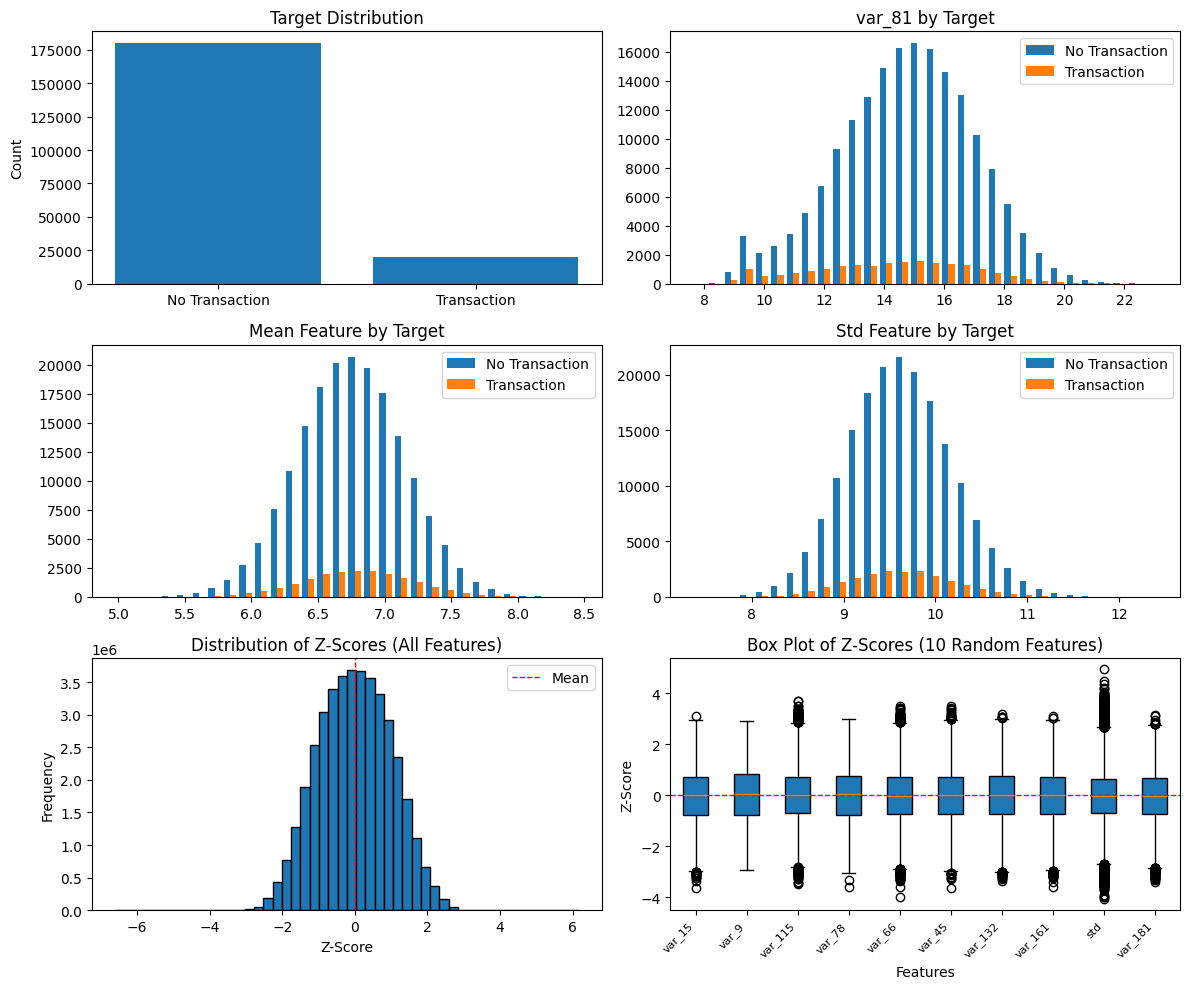

In [53]:
# Visualizations


fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Target distribution
axes[0, 0].bar(['No Transaction', 'Transaction'], y.value_counts().values)
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_ylabel('Count')

# Top correlated feature
top_feature = correlations.index[0]
axes[0, 1].hist([X[y==0][top_feature], X[y==1][top_feature]], 
                label=['No Transaction', 'Transaction'], bins=30)
axes[0, 1].set_title(f'{top_feature} by Target')
axes[0, 1].legend()


# Mean feature by target
axes[1, 0].hist([X[y==0]['mean'], X[y==1]['mean']], 
                label=['No Transaction', 'Transaction'], bins=30)
axes[1, 0].set_title('Mean Feature by Target')
axes[1, 0].legend()


# Stabdard deviation feature by target
axes[1, 1].hist([X[y==0]['std'], X[y==1]['std']], 
                label=['No Transaction', 'Transaction'], bins=30)
axes[1, 1].set_title('Std Feature by Target')
axes[1, 1].legend()


# Calculate z-scores for all features
from scipy import stats
X_zscore = stats.zscore(X)

# Select 10 random features for boxplot
np.random.seed(42)  
selected_features = np.random.choice(X.columns, size=10, replace=False)

# Histogram of z-scores (flattened across all features)
axes[2, 0].hist(X_zscore.values.flatten(), bins=50, edgecolor='black')
axes[2, 0].set_title('Distribution of Z-Scores (All Features)')
axes[2, 0].set_xlabel('Z-Score')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].axvline(x=0, color='r', linestyle='--', linewidth=1, label='Mean')
axes[2, 0].legend()

# Box plot of z-scores for 10 selected features
axes[2, 1].boxplot(X_zscore[selected_features].values, vert=True, patch_artist=True)
axes[2, 1].set_title('Box Plot of Z-Scores (10 Random Features)')
axes[2, 1].set_xlabel('Features')
axes[2, 1].set_ylabel('Z-Score')
axes[2, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[2, 1].set_xticklabels(selected_features, rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap - Top 10 Features')

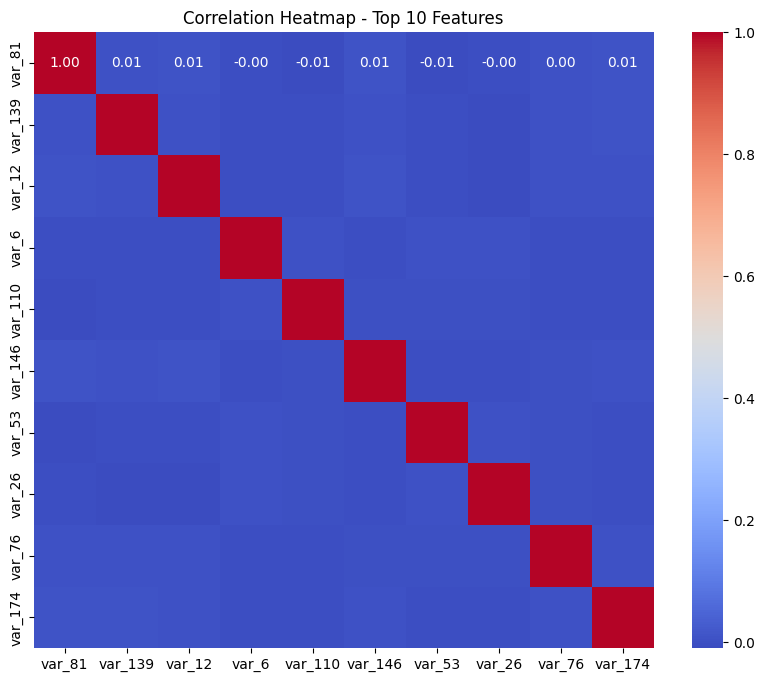

In [14]:
# Top features correlation heatmap
top_10 = correlations.head(10).index
corr_matrix = X[top_10].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap - Top 10 Features')

In [15]:
# Create pipeline with different scaling and PCA options
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


# Using subset of data for faster results
subset_size = 10000  # Use only 10k samples for grid search
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, train_size=subset_size, random_state=42, stratify=y_train
)
print(f"\nUsing subset of {subset_size} samples for grid search")

Train set: 160000 samples
Validation set: 40000 samples

Using subset of 10000 samples for grid search


In [ ]:
#might want to rename this later?

preprocessing_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Will be replaced in grid search
    ('pca', PCA()),  # Will be replaced in grid search
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Define parameter grid
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'pca__n_components': [None, 5, 10, 25, 50, 100],
    'model__C': [0.1, 1, 10, 20, 20, 100]
}


In [30]:
# Grid search on subset
grid_search = GridSearchCV(
    preprocessing_pipe, 
    param_grid, 
    cv=3,  
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

In [ ]:

grid_search.fit(X_train_subset, y_train_subset)

print(f"\nBest parameters:")
print(grid_search.best_params_)
print(f"\nBest CV AUC: {grid_search.best_score_:.4f}")

# Evaluate on validation set full
val_auc = roc_auc_score(y_val, grid_search.predict_proba(X_val)[:, 1])
print(f"Validation AUC: {val_auc:.4f}")

# Save best preprocessing pipeline
best_preprocessing = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [19]:
#Trying a Decision Tree Classifier 
#Based off code from my (Mia's) lab 11, and Aarya's code above 

tree_pipe = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA()),
    ('model', DecisionTreeClassifier())
])

tree_parms = {
    'model__max_depth': [2,3,4],
    'model__min_samples_split': [10,20,40],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'pca__n_components': [None, 5, 10, 25, 50, 100]
}

tree_grid_res = GridSearchCV(
    estimator = tree_pipe, 
    param_grid = tree_parms, 
    cv=5, 
    scoring = 'roc_auc').fit(X_train_subset, y_train_subset)

print(tree_grid_res.best_estimator_)
print(tree_grid_res.best_score_)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=100)),
                ('model',
                 DecisionTreeClassifier(max_depth=3, min_samples_split=10))])
0.7407572222222223
[CV] END model__C=0.1, pca__n_components=None, scaler=StandardScaler(); total time=   0.9s
[CV] END model__C=0.1, pca__n_components=5, scaler=MinMaxScaler(); total time=   0.3s
[CV] END model__C=0.1, pca__n_components=10, scaler=StandardScaler(); total time=   0.3s
[CV] END model__C=0.1, pca__n_components=10, scaler=MinMaxScaler(); total time=   0.3s
[CV] END model__C=0.1, pca__n_components=25, scaler=StandardScaler(); total time=   0.3s
[CV] END ....model__C=0.1, pca__n_components=25, scaler=None; total time=   0.3s
[CV] END model__C=0.1, pca__n_components=50, scaler=MinMaxScaler(); total time=   0.4s
[CV] END model__C=0.1, pca__n_components=100, scaler=MinMaxScaler(); total time=   0.8s
[CV] END model__C=1, pca__n_components=None, scaler=MinMaxScaler(); total time=   0.8s
[CV] END model